### Grover's Algorithm with Three Qubits

In [67]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-07-27 07:10:37,623: Credentials are already in use. The existing account in the session will be replaced.


In [39]:
from qiskit.aqua import *                        # importing the aqua packages, that have all the algos
from qiskit.aqua.components.oracles import *     # importing the oracle function, to make our oracle
from qiskit.aqua.algorithms import *             # importing all the algorithms, that we need

To specify the elements in the Grover's algorithm, we must use an oracle. Aqua offers the possibility of defining this oracle at high level, without giving the actual Quantum Gates, with TruthTableOracle.

TruthTableOracle receives a string of zeroes and ones of length $2^n$ that specifies what are the values of the oracle for thr $2^n$ binary strng in lexicographical order. For eg, with the string 0101 we will have a boolean function that it 0 on 00 and 10, but 1 on 01 and 11. 



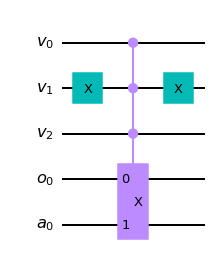

In [52]:
# defining the oracle
oracle = TruthTableOracle("00000100")                  # we need to find the element |101>
oracle.construct_circuit().draw(output='mpl')          # hence the oracle below

For $N= 8$, the operator $G$ will be applied $2$ times. The oracle is queried $2$ times. 
Classically,an average of more than $4$ queries are needed in order to have a probability of success of more than $1/2$.

Hence we have a Quadratic speed-up here.

In [61]:
g = Grover(oracle, iterations = 2)   # specifying the iterations to be two, which gives us more probability of finding correct answer

In [62]:
backend= Aer.get_backend('qasm_simulator')             # running on a Qasm Simulator backend

quantum_instance = QuantumInstance(backend)

In [59]:
result = g.run(quantum_instance)


In [60]:
print(result)

{'measurement': {'010': 8, '101': 969, '001': 4, '111': 6, '000': 14, '011': 8, '110': 5, '100': 10}, 'top_measurement': '101', 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f3697672d60>, 'assignment': [1, -2, 3], 'oracle_evaluation': True}


### Runnnig it on an Actual Quantum Computer

In [47]:
from qiskit.tools.monitor import * 
from qiskit.providers.ibmq import least_busy
# run on a quantum computer

provider = IBMQ.load_account()

backend = least_busy(provider.backends(operational = True, simulator = False, status_msg='active',
                                      filters=lambda x: x.configuration().n_qubits >3))
print("we are executing on ...", backend)
quantum_instance = QuantumInstance(backend)

result = g.run(quantum_instance)


ibmqfactory.load_account:WARNING:2021-07-27 06:14:48,843: Credentials are already in use. The existing account in the session will be replaced.


we are executing on ... ibmqx2


/opt/conda/lib/python3.8/site-packages/qiskit/aqua/utils/run_circuits.py:384: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)


In [48]:
print(result)

{'measurement': {'000': 126, '001': 113, '010': 172, '011': 123, '100': 136, '101': 87, '110': 155, '111': 112}, 'top_measurement': '010', 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f36978fe880>, 'assignment': [-1, 2, -3], 'oracle_evaluation': False}


### Grover's Algorithm as a Function


In [69]:
PI = np.pi

def groverCircuit(target):

    target_list = [int(x) for x in str(target)] #Converts the target into a list (e.g '1001' => [1,0,0,1])
    n = len(target_list) #Length of target list (i.e nbr of qubits)
    counter = [i for i in range(n)] #List containing integers from 0 to num_qubits - 1

    #Defining a CnP gate. Note that CnP(PI) = CNZ
    def mcp(self, lam, control_qubits, target_qubit):
        from qiskit.circuit.library import MCPhaseGate
        num_ctrl_qubits = len(control_qubits)
        return self.append(MCPhaseGate(lam, num_ctrl_qubits), control_qubits[:] + [target_qubit],
                    [])

    #Sub-circuit 1: Hadamard on all qubits
    def hadamards(target):
        hadCirc = QuantumCircuit(n,n)
        hadCirc.h(counter)
        hadCirc.barrier()
        return hadCirc

    #Sub-circuit 2: Oracle 
    def oracle(target):
        filtered = [counter[i] for i in range(n) if target_list[i]==0] #Filtering the counter list to only the indices where target==0
        oracleCirc = QuantumCircuit(n,n)
        if filtered != []:
            oracleCirc.x(filtered) #In other words, if target only has 1s, do nothing 
        mcp(oracleCirc, np.pi, [i for i in range(n-1)],n-1)
        if filtered != []:
            oracleCirc.x(filtered) #Applying X gates to the qubits which represent 0
        oracleCirc.barrier()
        return oracleCirc

    #Sub-circuit 3: Amplifier
    def amplification(target):
        ampCirc = QuantumCircuit(n,n)
        ampCirc.h(counter)
        ampCirc.x(counter)
        mcp(ampCirc, np.pi, [i for i in range(n-1)],n-1)
        ampCirc.x(counter)
        ampCirc.h(counter)
        ampCirc.barrier()
        return ampCirc

    k = round(PI*n/4 - 0.5) #Ideal number of iterations. k = π/4 * √N - 1/2. 

    circuit = hadamards(target) 

    for i in range(k): #Iterating the oracle and amplification 
        circuit+=oracle(target)
        circuit+= amplification(target)

    circuit.measure(counter, counter)
    return circuit

In [70]:

from qiskit.tools.visualization import plot_histogram
circuit = groverCircuit('1001')   # doing it for a 4-qubit

#### Running it on Actual Quantum Computers (which shows Error)

least busy backend:  ibmqx2


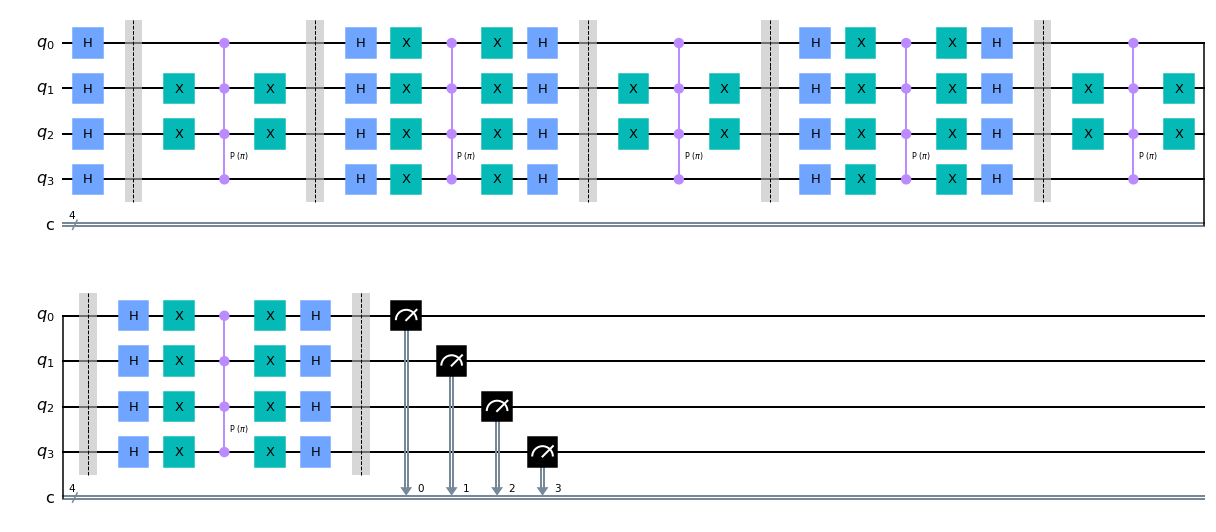

In [71]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

result = execute(circuit,backend= backend, shots = 1024).result()
output = result.get_counts()
circuit.draw('mpl')

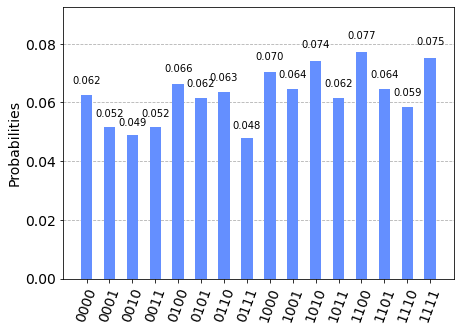

In [72]:
plot_histogram(output)

#### Running it on Quantum Simulator (which is near ideal)

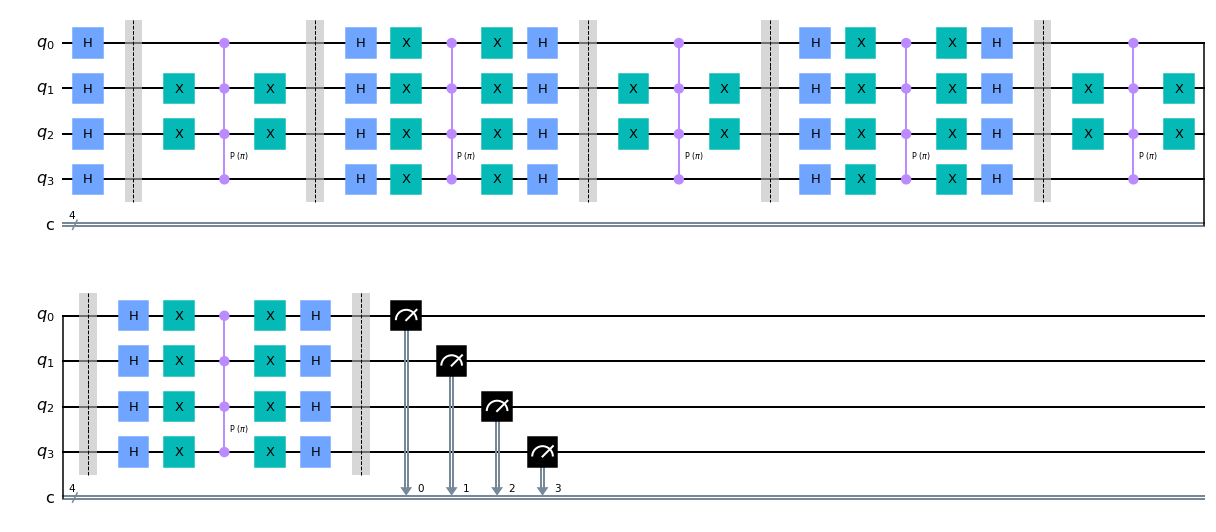

In [73]:
from qiskit.tools.visualization import plot_histogram
circuit = groverCircuit('1001')

backend = Aer.get_backend('qasm_simulator')
result = execute(circuit,backend, shots = 420).result()
output = result.get_counts()
circuit.draw('mpl')

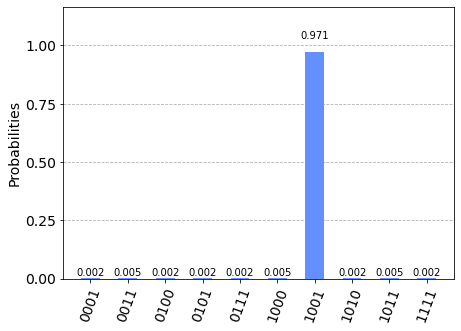

In [74]:
plot_histogram(output)

### Grover's Algorithm for a Three-Qubit System

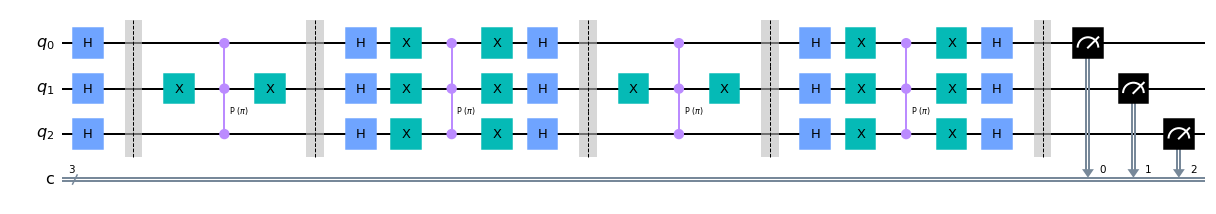

In [75]:
from qiskit.tools.visualization import plot_histogram
circuit = groverCircuit('101')

backend = Aer.get_backend('qasm_simulator')
result = execute(circuit,backend, shots = 420).result()
output = result.get_counts()
circuit.draw('mpl')

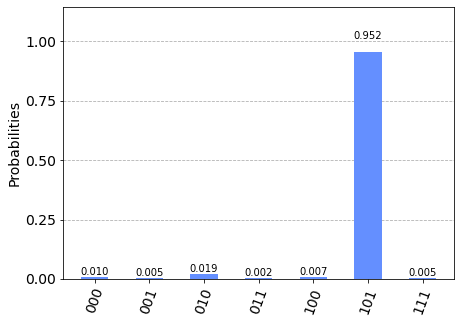

In [76]:
plot_histogram(output)

With the total of 1024 shots, we get the desired output with a probability of 0.952 or 95.2% of times. Which is near our theoretically calculated value of 0.945 or 94.5%

### Grover's Algorithm for a 5-Qubit system

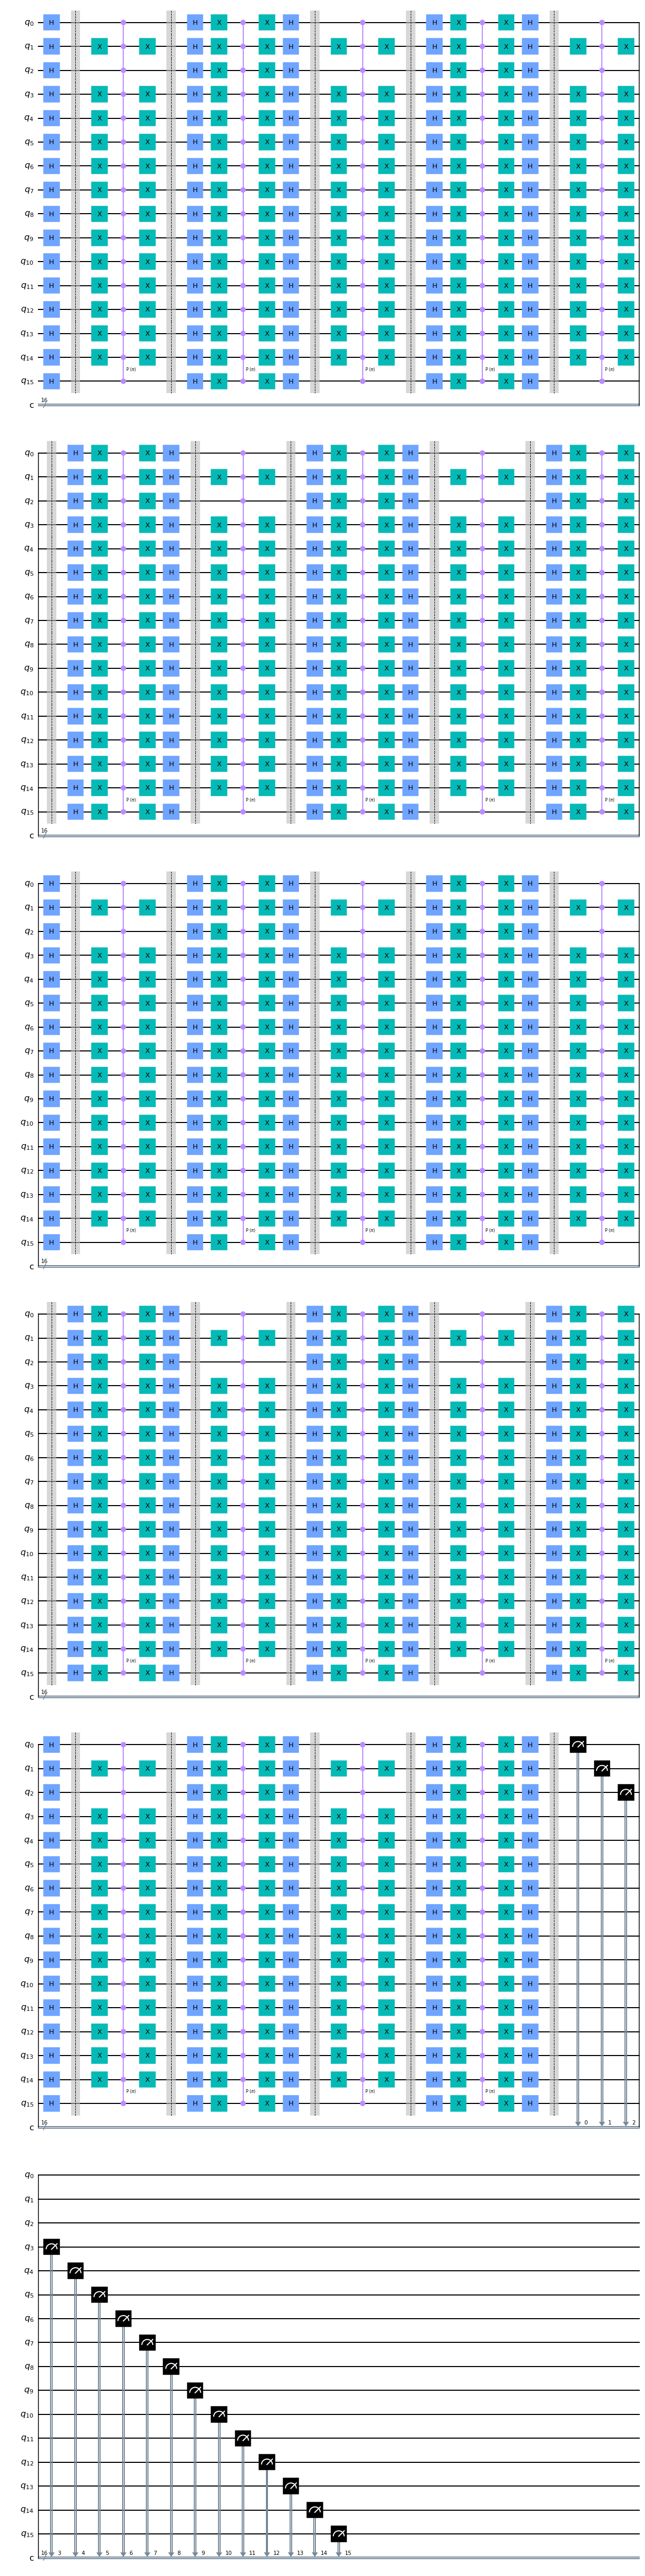

In [77]:
from qiskit.tools.visualization import plot_histogram
circuit = groverCircuit('1010000000000001')

backend = Aer.get_backend('qasm_simulator')
result = execute(circuit,backend, shots = 420).result()
output = result.get_counts()
circuit.draw('mpl')

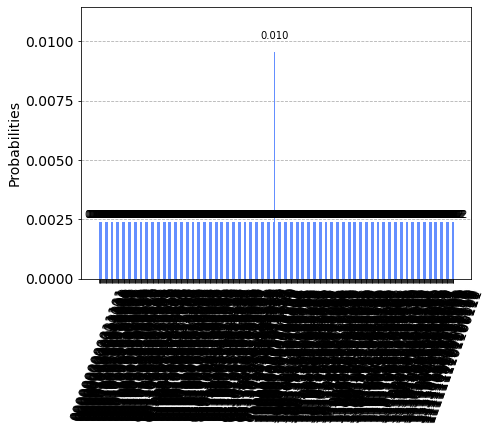

In [78]:
plot_histogram(output)